In [1]:
import pandas as pd
import numpy as np
from seaborn import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
# load the data 

df = load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
cols_to_remove = df.columns[8:].append(df.columns[[4,5]])

In [5]:
# remove unecessary columns from the df

df.drop(columns=cols_to_remove,inplace=True)

df.head()

,survived,pclass,sex,age,fare,embarked
0,0,3,male,22.0,7.2500,S
1,1,1,female,38.0,71.2833,C
2,1,3,female,26.0,7.9250,S
3,1,1,female,35.0,53.1000,S
4,0,3,male,35.0,8.0500,S


In [6]:
# check for missing values in the data

df.isna().sum()

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
dtype: int64

- The embarked column has only two missing values
- The age column has greater than 150 missing values

In [7]:
# data types of columns in the data

df.dtypes

survived      int64
pclass        int64
sex          object
age         float64
fare        float64
embarked     object
dtype: object

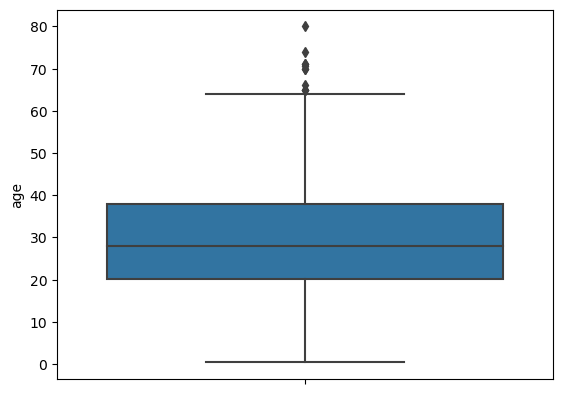

In [8]:
# check for outliers in the age column

sns.boxplot(data=df,y='age')
plt.show()

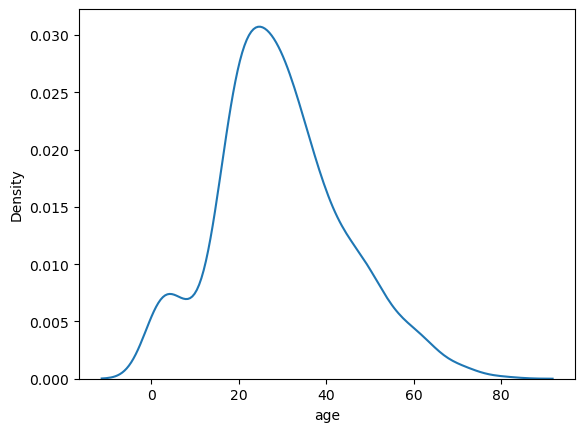

In [9]:
# distribution of the age column

sns.kdeplot(data=df,x='age')
plt.show()

In [10]:
# split the data into X and y

X = df.drop(columns=['survived'])

y = df['survived']

In [11]:
# do the train test split of the data

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=45)

print('The shape of the training data is',X_train.shape)
print('The shape of the test data is',X_test.shape)

The shape of the training data is (712, 5)
The shape of the test data is (179, 5)


In [12]:
# check for the missing values in the train and test data

train_missing = X_train.isna().sum()

test_missing = X_test.isna().sum()

print(train_missing,test_missing,sep='\n'*3)

pclass        0
sex           0
age         144
fare          0
embarked      2
dtype: int64


pclass       0
sex          0
age         33
fare         0
embarked     0
dtype: int64


## What is Mean/Median imputation and where to use it?

   Mean and median imputation are common techniques used to handle missing data in a dataset. They both involve filling in missing values with a central tendency measure. The choice between using mean or median imputation depends on the nature of the data and the underlying assumptions.

Mean imputation is generally considered appropriate when the data has a normal distribution or is approximately symmetric. It is also suitable when the missing data is missing completely at random (MCAR) or missing at random (MAR). However, mean imputation may not be ideal when dealing with data that is skewed or has outliers, as the mean can be influenced by extreme values.

On the other hand, median imputation is more robust to outliers and skewed data. It is a better option when the data is not normally distributed or if the data has a substantial number of extreme values. Median imputation is also preferred when the missing data is not MCAR but missing at random (MAR) or missing not at random (MNAR).

In summary, mean imputation can be used when:

1. Data is approximately normally distributed or symmetric.
2. The missing data is MCAR or MAR.
3. There are no significant outliers.

Median imputation can be used when:

1. Data is skewed or has outliers.
2. The missing data is MAR or MNAR.

It's important to note that both mean and median imputation may introduce bias and potentially underestimate the variability in the data. Therefore, imputation should be used with caution, and other advanced imputation methods like multiple imputation or model-based imputation may be more appropriate depending on the specific dataset and analysis goals. Additionally, always document the imputation process and consider sensitivity analyses to assess the impact of imputatthe results..
</div>


In [13]:
# create the imputer class

class MyImputer:

    def __init__(self,mapper):
        self.X = X
        self.mapper = mapper
        self.imputer_objs = {}
        self.trans = None
        
        for key in self.mapper.keys():
            self.imputer_objs[key] = SimpleImputer(strategy=mapper.get(key))
        
        columns = list(self.imputer_objs.keys())

        transformers = []
        
        for i in range(len(self.imputer_objs)):
            column = [columns[i]]
            name = f'trans{i+1}'
            imputer = self.imputer_objs[column[0]]
            res = (name,imputer,column)
            transformers.append(res)

        
        self.trans = ColumnTransformer(transformers=transformers,
                                      remainder='passthrough',
                                      n_jobs=-1).set_output(transform='pandas')   
    
        
        
    def fit(self,X):
        # fit the column transformer

        self.trans.fit(X)

    def transform(self,X):
        # transform the data from the transformer

        X_trans = self.trans.transform(X)
        return X_trans


class plotting:

    def __init__(self,X_original,X_transformed):
        self.X = X_original
        self.X_trans = X_transformed


    def boxplots(self,column):
        fig,ax = plt.subplots(1,2,figsize=(15,8))

        # plot the first boxplot
        sns.boxplot(data=self.X,y=column,ax=ax[0])
        ax[0].set_title('Boxplot for the original data')

        # plot the second boxplot
        sns.boxplot(data=self.X_trans,y=column,ax=ax[1])
        ax[1].set_title('Boxplot for the transformed data')
        plt.show()

    
    def kdeplot(self,column,func):
        # plot the first kdeplot
        sns.kdeplot(data=self.X,x=column,label='Before Imputation')

        # plot the second kdeplot
        if func == 'median':
            sns.kdeplot(data=self.X_trans,x=column,label='After Imputation')
            plt.axvline(x=self.X[column].median(),linestyle='dashed')
            plt.axvline(x=self.X_trans[column].median(),linestyle='dashed')
            plt.legend()
            plt.show()
        elif func == 'mean':
            sns.kdeplot(data=self.X_trans,x=column,label='After Imputation')
            plt.axvline(x=self.X[column].mean(),linestyle='dashed')
            plt.axvline(x=self.X_trans[column].mean(),linestyle='dashed')
            plt.legend()
            plt.show()
    
    def countplot(self,column):
        fig,ax = plt.subplots(1,2,figsize=(15,8))

        # plot the first countplot
        sns.countplot(data=self.X,x=column,ax=ax[0])
        ax[0].set_title('Countplot for the original data')

        # plot the second countplot
        sns.countplot(data=self.X_trans,x=column,ax=ax[1])
        ax[1].set_title('Countplot for the transformed data')
        plt.show()

    def plot_covariance_matrix(self):
        if isinstance(self.X,pd.DataFrame) and isinstance(self.X_trans,pd.DataFrame):
            num_cols = self.X.select_dtypes(include=np.number).columns
            cov_original = self.X[num_cols].cov()
            cov_transformed = self.X_trans[num_cols].cov()
    
            # plot the covariance matrix 
            fig,ax = plt.subplots(1,2,figsize=(15,8))

            # plot the first heatmap
            sns.heatmap(cov_original,annot=True,ax=ax[0])
            ax[0].set_title('Heatmap for the original data')
        
            # plot the second heatmap
            sns.heatmap(cov_transformed,annot=True,ax=ax[1])
            ax[1].set_title('Heatmap for the transformed data')
            plt.show()
            
        else:
            return 'pass the inputs as dataframe only'
        

In [14]:
mapper = {'age':'median','embarked':'most_frequent'}

imputer = MyImputer(mapper)

# fit on the X_train
imputer.fit(X_train)

# transform the train data
X_train_trans = imputer.transform(X_train)

# transform the test data
X_test_trans = imputer.transform(X_test)

In [15]:
# check for sum of missing values in the train data

X_train_trans.isna().sum().sum()

0

In [16]:
# check for sum of missing values in the test data

X_test_trans.isna().sum().sum()

0

In [17]:
# print the columns of X_train_trans

X_train_trans.columns = [x[1] for x in X_train_trans.columns.str.split('__').to_list()]

In [18]:
X_test_trans.columns = [x[1] for x in X_test_trans.columns.str.split('__').to_list()]

In [19]:
# print the columns after transformation

X_train_trans.head(3)

,age,embarked,pclass,sex,fare
332,38.0,S,1,male,153.4625
281,28.0,S,3,male,7.8542
147,9.0,S,3,female,34.3750


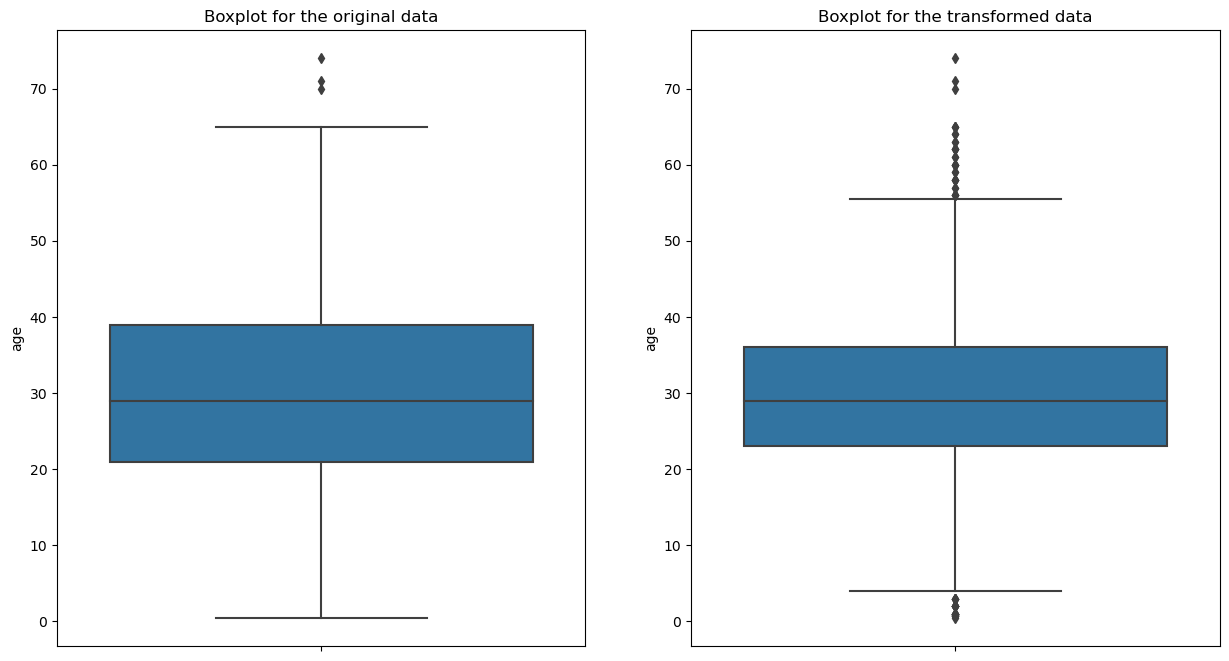

In [20]:
# plot the graphs to check for the distribution before and after imputation

plotter = plotting(X_original=X_train,X_transformed=X_train_trans)

# plot the boxplot for the age column

plotter.boxplots('age')

Mean and median imputation can potentially create more outliers in the data when you plot boxplots because both methods involve replacing missing values with a single value (mean or median) for the entire variable. This replacement can lead to an increase in the concentration of data points around the imputed value, causing the distribution to become more peaked or extreme.

Let's look at each case separately:

1. Mean Imputation:
When using mean imputation, missing values are replaced with the mean of the non-missing values in the variable. This approach can be problematic if the variable has outliers, as the mean is sensitive to extreme values. If the variable has some extreme values, the imputed values may be quite different from the original values, effectively pulling the data points towards the center. As a result, the range of data values becomes more compact, leading to the appearance of more outliers in the boxplot.

2. Median Imputation:
Median imputation is more robust to outliers compared to mean imputation. However, it can still create more apparent outliers in the boxplot when there are missing values at the extremes of the distribution. The median imputation process may introduce a higher concentration of data points around the median, which can cause the data to appear more dispersed and lead to the detection of additional outliers.

**In both cases, imputation can potentially increase the apparent variability in the data and, consequently, the number of data points considered as outliers. It's essential to understand that these newly detected outliers might not have been present in the original data but are an artifact of the imputation process.**


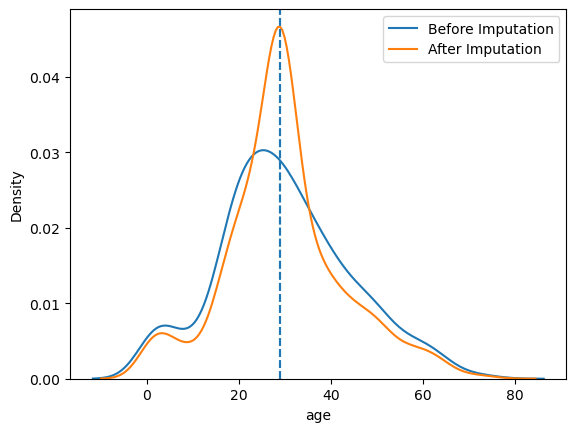

In [24]:
# plot the kde plot for the age column

plotter.kdeplot('age','median')




1. Mean Imputation:
When using mean imputation, missing values are replaced with the mean of the non-missing values in the variable. This process effectively shifts the imputed values towards the center of the distribution. As a result, the KDE plot will show a more pronounced peak around the mean, making the distribution appear more symmetric. However, mean imputation can underestimate the variability of the data and flatten the tails of the distribution.

If the variable has outliers, mean imputation can have an even more significant impact. The presence of extreme values in the data will pull the mean towards them, leading to a distorted peak in the KDE plot. The tails of the distribution might be stretched to accommodate these extreme values, resulting in a more pronounced, but artificial, multimodal appearance.

2. Median Imputation:
Median imputation is more robust to outliers compared to mean imputation. When using median imputation, missing values are replaced with the median of the non-missing values in the variable. This process tends to preserve the center of the distribution and makes the KDE plot less sensitive to extreme values. The resulting KDE plot will have a peak around the median, but it may also retain the original shape of the distribution better than mean imputation.

However, median imputation can still impact the KDE plot, especially if there are many missing values around the tails of the distribution. In such cases, the tails of the KDE plot may be more heavily influenced by the imputed values, leading to distortions in those areas.

Overall, both mean and median imputation can affect the KDE plot distributions by altering the central tendency of the data and potentially introducing artificial peaks or flattening the tails. It's important to consider the impact of imputation on the distribution when using these techniques and to be cautious about interpreting the resulting KDE plots. In situations where missing data is substantial or influential, more sophisticated imputation methods may be preferable to better preserve the true underlying distribution of the data.n of the data.

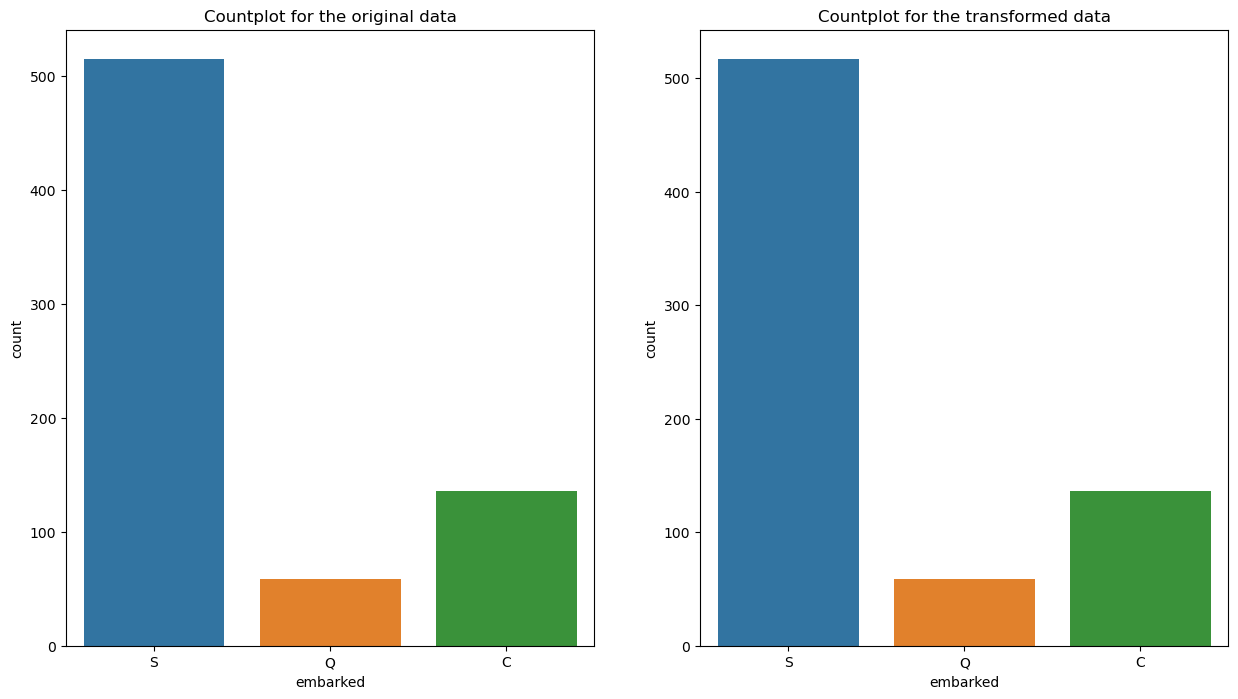

In [25]:
# plot the countplot for the embarked column

plotter.countplot('embarked')

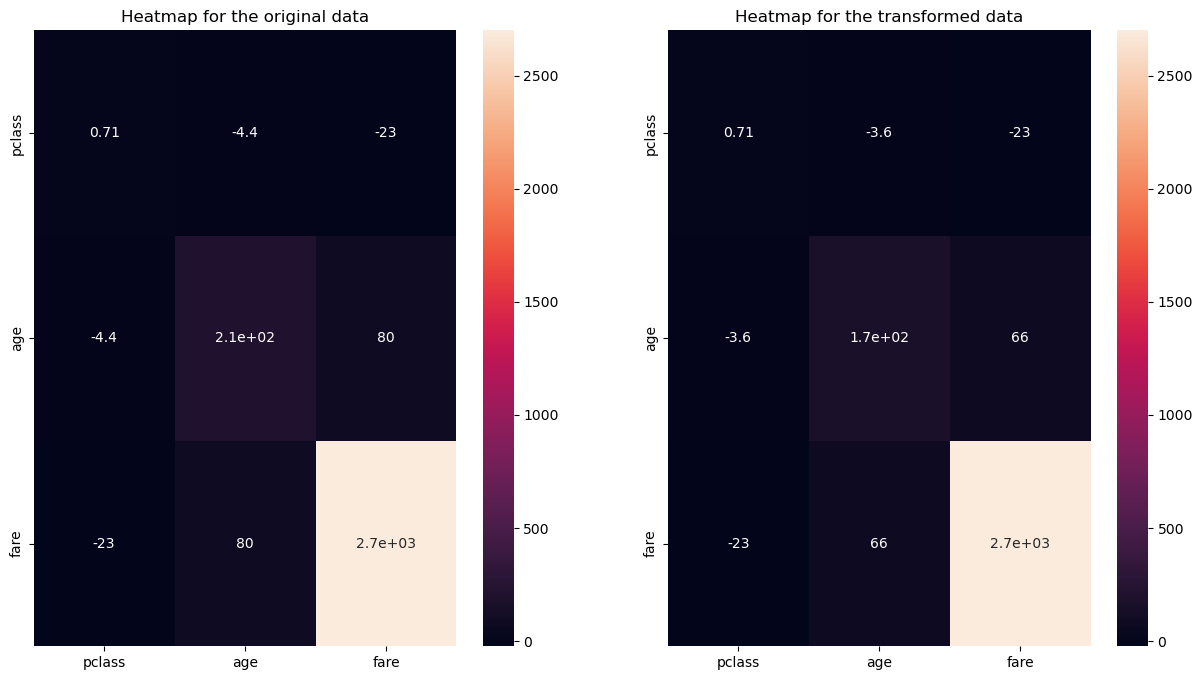

In [26]:
# covariance matrix for the data

plotter.plot_covariance_matrix()

The covariance of the data can be influenced by imputation, especially when imputing missing values using summary statistics like mean or median. Let's explore how covariance can change due to imputation:

1. Mean Imputation:
When using mean imputation, missing values are replaced with the mean of the non-missing values for each variable. This replacement affects the covariance because the imputed values are fixed and constant. Consequently, the covariance between the variable being imputed and other variables will tend to be shifted towards the mean.

Specifically:
- If the original missing values were less than the mean of the variable, mean imputation will increase the covariance with other variables since the imputed values are now closer to the mean.
- Conversely, if the original missing values were greater than the mean, mean imputation will decrease the covariance with other variables because the imputed values are now closer to the mean.

The covariance with other variables may also change indirectly because mean imputation can lead to a decrease in variability due to the imputed values being more clustered around the mean. This can lead to a reduction in the spread of the data, affecting the overall covariance structure.

2. Median Imputation:
Median imputation replaces missing values with the median of the non-missing values for each variable. As with mean imputation, this imputed value is fixed and constant. However, median imputation is more robust to outliers, and as a result, the impact on covariance is generally less pronounced compared to mean imputation.

Median imputation tends to preserve the rank order of the data, which means that the relative ordering of values within a variable is maintained. As a result, the covariance with other variables might be less affected than with mean imputation, especially in the presence of extreme values.

In summary, mean and median imputation can change the covariance of the data, with mean imputation potentially having a more pronounced impact on the covariance structure. However, the degree of change will depend on the nature of the missing data, the presence of outliers, and the specific characteristics of the dataset.